# Topic Modeling:<br/>

<p> Here, we are using Latent Dirichlet Allocation(LDA) is a clustering algorithm which gives us the number of topics based on group of words. </p> <br/>

<p> LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.</p><br/>


<img src="LDA.png"/>

<br/>

## Steps for Topic Modeling: 
<br/>
<b>1. Loading data </b> <br/>
<b>2. Data cleaning </b> <br/>
<b>3. Exploratory analysis </b> <br/>
<b>4. Preparing data for LDA analysis </b> <br/>
<b>5. LDA model training </b> <br/>
<b>6. Analyzing LDA model results </b> <br/>

<i> https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 </i>

In [64]:
# Import Library
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

In [63]:
# Read data from csv file
dataset = pd.read_csv('.\data\papers.csv')

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-63-d8b28006deb0>:2: DeprecationWarning: invalid escape sequence \d
  dataset1 = pd.read_csv('.\data\papers.csv')


In [5]:
dataset.head(5)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [6]:
# Drop all un-necessary columns
dataset = dataset.drop(columns=["id", "year", "title", "event_type", "pdf_name", "abstract"])

In [7]:
# Remove punctuations from text
dataset.head(5)

,paper_text
0,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,Bayesian Query Construction for Neural\nNetwor...
4,"Neural Network Ensembles, Cross\nValidation, a..."


In [24]:
# Clean the data 
corpus=[]
# Here I have provcessed 500 texts which takes about 10 minutes. But you can increase # of rows to process. 
for i in tqdm(range(500)):
    # Remove \n from the text
    str1 = str(dataset["paper_text"].iloc[i])
    str1 = str1.replace("\n", " ")
    
    # Remove punctuations and symbols
    str1 = re.sub("[^a-zA-Z0-9]", " ", str1)
    
    # Convert string to lower
    str1 = str1.lower()
    
    # Remove stop words
    str1 = [i for i in str1.split() if i not in set(stopwords.words('english'))]
    
    # Delete uni-character symbols and letters
    str1 = [i for i in str1 if len(i)>=2]
    
    # Append the clean text to corpus 
    corpus.append(" ".join(str1))

100%|██████████| 500/500 [10:44<00:00,  1.29s/it]


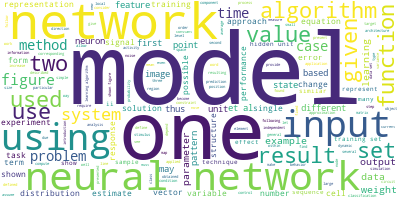

In [25]:
# Lets create a Pandas dataframe using our cleaned corpus
df = pd.DataFrame(corpus, columns=["Processed_Text"])

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['Processed_Text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

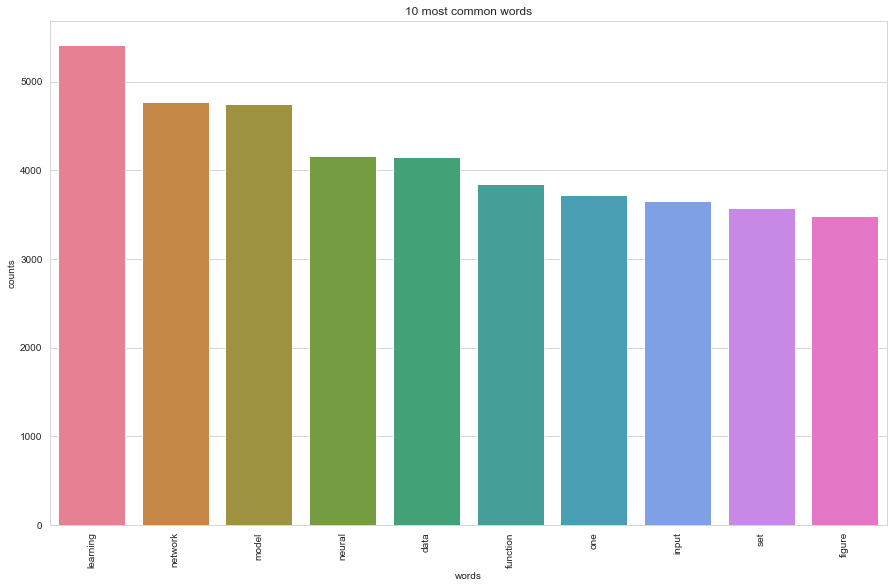

In [30]:
# Prepare text for LDA Analysis
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer() # Use this code for getting uni and bi-grams "CountVectorizer(ngram_range=(1, 2))"
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['Processed_Text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [46]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)


Topics found via LDA:

Topic #0:
model input network time neural one figure system units neurons

Topic #1:
learning state model function control time value system network policy

Topic #2:
network figure input output neural circuit one using two time

Topic #3:
learning function algorithm data training set networks network error neural

Topic #4:
data set image model using used images figure recognition training


In [50]:
# For visualizing Topics we need to input 3 things to PyLdavis 
# 1. Lda Model 2. Vectorized matrix and 3. Vectorizer type(In this case, its Count Vectorizer)

# Note: We can use Tf-idf instead of Count Vectorizer
vis = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)